# AfroTech Company

# Business Understanding

AfroTech Company is developing a movie recommendation engine for streaming platforms to enhance user experience through personalized content suggestions. With the rapid expansion of digital movie libraries, users often struggle to discover content aligned with their interests. This leads to decision fatigue, reduced engagement, and increased churn, while valuable content remains underutilized.

To address this, AfroTech’s system will use collaborative filtering techniques—specifically Singular Value Decomposition (SVD) and Least Squares Optimization—to uncover latent patterns in user preferences and movie features. The model will predict unseen ratings and generate relevant recommendations, helping users find content more efficiently.

The primary business objectives are to improve user satisfaction, increase engagement, enhance content discovery, and support long-term user retention through personalized experiences.

Success will be measured by:
- Achieving an RMSE of 0.90 or lower (or MAE <= 0.70) for accurate predictions,
- Reaching at least 95% coverage of users and movies,
- Maintaining a click-through rate of 20% or higher on recommendations,
- Ensuring an average time to first watch under three minutes,
- Achieving 70% user retention over 30 days,
- And maintaining a cosine similarity of 0.85 or higher between latent feature vectors across training runs.

These outcomes will demonstrate the system’s ability to deliver accurate, scalable, and user-focused recommendations that align with AfroTech’s business goals.



# Data Understanding

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt

from surprise import Reader, Dataset, SVD
from surprise import accuracy, KNNBasic
from surprise.model_selection import cross_validate, train_test_split

from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


explanation of the libraries!:
- surprise is the library for recommender systems
- Dataset is for the datasets, duh!
- Reader defines the rating scale [1-5]
- cross_validate checks model perfomance(hii tushasoma sistee)

In [2]:
# #load dataset (movie lens )
# #it's built in the surprise library
# r = Dataset.load_builtin('ml-100k')

# d = pd.DataFrame(r.raw_ratings, columns=['user_id','movie_id','rating','timestamp'])
# d[:3]

In [3]:
#load the datasets
links = pd.read_csv('ml-latest-small/links.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
print(f'Movies:\n{movies[:3]}\n')
print(f'Links:\n{links[:3]}\n')
print(f'Ratings:\n{ratings[:3]}\n')
print(f'Tags:\n{tags[:3]}\n')

Movies:
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  

Links:
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0

Ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224

Tags:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992



The datasets contains columns:
- ratings.csv: userId, movieId, rating, timestamp -> this is the core data for matrix factorization.
- movies.csv: movieId, title, genres -> essential for naming recommendations and possible genre analysis.
- tags.csv: userId, movieId, tag, timestamp -> optional for content-based hybrid recommendations (could enrich model later).
- links.csv: movieId, imdbId, tmdbId -> useful if you want to pull external metadata (optional for now) for deployment.

Observation:
- All datasets have a column 'movieId'
- in data cleaning we will have all the column names in lowecase

# Data Cleaning

1. Ratings

In [4]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [5]:
#check data types, shape, duplicates and missing values in ratings
print(f'The datatypes are:\n{ratings.dtypes}\n')
print(f'Ratings has {ratings.shape[0]} rows and {ratings.shape[1]}columns\n')
print(f'Ratings has:\n{ratings.isna().sum()} missing values\n')
print(f'Ratings has:{ratings.duplicated().sum()} duplicates')

# have all column names in lowercase
ratings.columns = ratings.columns.str.lower()
print(ratings.columns)

The datatypes are:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Ratings has 100836 rows and 4columns

Ratings has:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 missing values

Ratings has:0 duplicates
Index(['userid', 'movieid', 'rating', 'timestamp'], dtype='object')


2. Movies

In [6]:
#check data types, shape, duplicates and missing values in movies
print(f'The datatypes are:\n{movies.dtypes}\n')
print(f'Movies has {movies.shape[0]} rows and {movies.shape[1]}columns\n')
print(f'Movies has:\n{movies.isna().sum()} missing values\n')
print(f'Movies has:{movies.duplicated().sum()} duplicates')

# have all column names in lowercase
movies.columns = movies.columns.str.lower()
print(movies.columns)

The datatypes are:
movieId     int64
title      object
genres     object
dtype: object

Movies has 9742 rows and 3columns

Movies has:
movieId    0
title      0
genres     0
dtype: int64 missing values

Movies has:0 duplicates
Index(['movieid', 'title', 'genres'], dtype='object')


3. Links

In [7]:
#check data types, shape, duplicates and missing values in links
print(f'The datatypes are:\n{links.dtypes}\n')
print(f'links has {links.shape[0]} rows and {links.shape[1]}columns\n')
print(f'links has:\n{links.isna().sum()} missing values\n')
print(f'links has:{links.duplicated().sum()} duplicates')

# have all column names in lowercase
links.columns = links.columns.str.lower()
print(links.columns)

The datatypes are:
movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

links has 9742 rows and 3columns

links has:
movieId    0
imdbId     0
tmdbId     8
dtype: int64 missing values

links has:0 duplicates
Index(['movieid', 'imdbid', 'tmdbid'], dtype='object')


In [8]:
# drop the missing values in tmbdid
links = links.dropna()
links.isna().sum()
print(links.shape)

(9734, 3)


4. tags

In [9]:
#check data types, shape, duplicates and missing values in tags
print(f'The datatypes are:\n{tags.dtypes}\n')
print(f'tags has {tags.shape[0]} rows and {tags.shape[1]}columns\n')
print(f'tags has:\n{tags.isna().sum()} missing values\n')
print(f'tags has:{tags.duplicated().sum()} duplicates')

# have all column names in lowercase
tags.columns = tags.columns.str.lower()

The datatypes are:
userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object

tags has 3683 rows and 4columns

tags has:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64 missing values

tags has:0 duplicates


In [10]:
tag_characters = tags['tag'].value_counts()
tag_characters

tag
In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
funny                 23
                    ... 
small towns            1
In Your Eyes           1
Lloyd Dobbler          1
weak plot              1
Heroic Bloodshed       1
Name: count, Length: 1589, dtype: int64

Observation:
- The tags dataset has the least amount of rows compared to the other 3 datasets
 * Upside:
  - It may be useful to use when recommending using content-based features
    - eg-> when recommending 'thrillers' to a user who rated a thriller highly
  - It makes it easy to explain why we recommend a certain movie
    - eg-> recommended because you liked horror movies
  - it makes the recommendation diverse since it combines latent factors with tag-based similarities
  - We could cluster the tags to group movies by themes (cosine similarities)
* Downside:
  - The dataset is too small comapred to ratings with more than 10k entries
  - Since tags are user generated, some of the entries may lack meaning to us
    - eg-> a users entry like 'beautiful' may not be meaningful information to us
- Due to lack of quality and sizable info from tags, we will hae to let it go (not merge)
- Movie genres will have to work in place of tags

### Merging the datasets

In [11]:
#The most important dataset is ratings
rate_movie = pd.merge(ratings,movies, on='movieid',how='left')
rate_movie[:3]

,userid,movieid,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller


In [12]:
#merge rate_movie and links
data = pd.merge(rate_movie,links,how='left',on='movieid')
data[:3]

,userid,movieid,rating,timestamp,title,genres,imdbid,tmdbid
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709.0,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,113228.0,15602.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,113277.0,949.0


In [13]:
# Sanity check
print("Ratings:",ratings.shape)
print("Movies:",movies.shape)
print("Links:",links.shape)
print("Merged Dataset:",data.shape)

Ratings: (100836, 4)
Movies: (9742, 3)
Links: (9734, 3)
Merged Dataset: (100836, 8)


In [14]:
# check for missing values & drop them
data.isna().sum()
data.dropna()
data.isna().sum()
 # Dropped the 13 missing rows in imdbid and tmdbid

userid        0
movieid       0
rating        0
timestamp     0
title         0
genres        0
imdbid       13
tmdbid       13
dtype: int64

In [15]:
#check for duplicates
print(f"The dataset has{data.duplicated().sum()} duplicates")

The dataset has0 duplicates


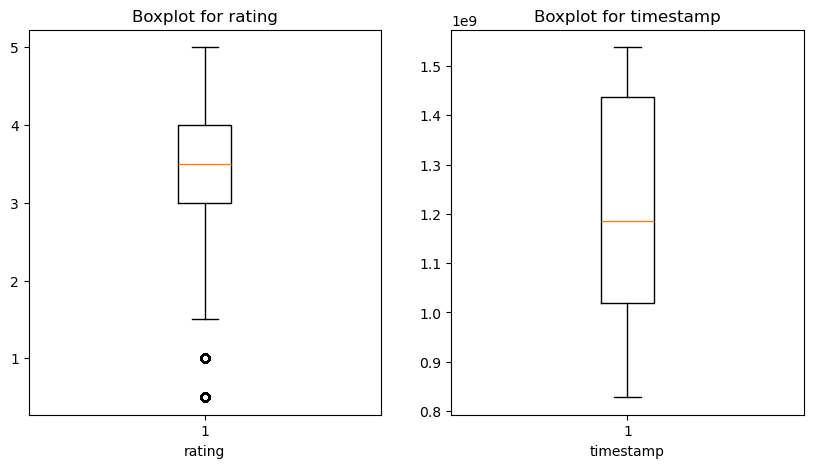

In [16]:
#check outliers
num_cols = data[['rating','timestamp']]
fig,ax = plt.subplots(ncols=2,figsize=(10,5))
for i,col in enumerate(num_cols):
    ax[i].boxplot(data[col])
    ax[i].set_title(f"Boxplot for {col}")
    ax[i].set_xlabel(col)

Observation:
- The outliers are genuine since some movies are longer than other and ratings less than 1 make sense too

In [17]:
# make a copy of the merged dataset
data.to_csv('merged_clean_movies.csv',index=False)

# Exploratory Data Analysis

# Modeling

In [18]:
#separate data for modeling
ratings_data = data[['userid','movieid','rating']]

#define rating scale
reader = Reader(rating_scale=(0.5,5.0))

#load into surprise dataset
surprise_data = Dataset.load_from_df(ratings_data,reader)


### Cosine Similarity using KNN basic

In [19]:
#define similarity options
sim_option = {'name': 'cosine', 'user_based':False}#item-item similarity

#initialize algorithm
knn_algo = KNNBasic(sim_options=sim_option)

#cross validate for knn algorithm
cv_results_knn = cross_validate(knn_algo, surprise_data, measures=['RMSE','MAE'], cv=5, verbose=True)
print("Mean CV RMSE (KNN Cosine):", cv_results_knn['test_rmse'].mean())
print("Mean CV MAE (KNN Cosine):", cv_results_knn['test_mae'].mean())

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9722  0.9750  0.9730  0.9772  0.9820  0.9759  0.0035  
MAE (testset)     0.7579  0.7595  0.7588  0.7613  0.7651  0.7605  0.0026  
Fit time          2.23    1.81    1.62    1.70    1.52    1.78    0.25    
Test time         2.70    2.64    2.62    2.60    2.58    2.62    0.04    
Mean CV RMSE (KNN Cosine): 0.9758804806490728
Mean CV MAE (KNN Cosine): 0.7605125396819528


In [20]:
#train on full dataset
knn_trainset = surprise_data.build_full_trainset()
knn_algo.fit(knn_trainset)
#predict for user 196
# Get all movie ids from trainset
all_items = knn_trainset.all_items()
all_items_ids = [knn_trainset.to_raw_iid(iid) for iid in all_items]

# Pick user
user_id = 196
predictions_knn = [knn_algo.predict(user_id, iid) for iid in all_items_ids]

# Sort by estimated ratings
top_5_knn = sorted(predictions_knn, key=lambda x: x.est, reverse=True)[:5]

# Put into DataFrame with movie titles
top_5_knn_df = pd.DataFrame([(pred.iid, round(pred.est, 2)) for pred in top_5_knn],
                            columns=['movieid','pred_rating'])

top_5_knn_with_names = top_5_knn_df.merge(movies, on='movieid')[['movieid','title','pred_rating']]

print("\nTop-5 Recommended Movies for User 196 (Cosine Similarity):")
print(top_5_knn_with_names)


Computing the cosine similarity matrix...
Done computing similarity matrix.

Top-5 Recommended Movies for User 196 (Cosine Similarity):
   movieid                          title  pred_rating
0      128          Jupiter's Wife (1994)          5.0
1     7815            True Stories (1986)          5.0
2     8015  Phantom Tollbooth, The (1970)          5.0
3     3567              Bossa Nova (2000)          5.0
4     2370     Emerald Forest, The (1985)          5.0


### SVD

1. cross validation

In [21]:
#instantiate the model
algo = SVD()

#split the dataset
cv_svd = cross_validate(algo,surprise_data,measures=['RMSE','MAE'],cv=5,verbose=True)
print("Mean CV RMSE (SVD):", cv_svd['test_rmse'].mean())
print("Mean CV MAE (SVD):", cv_svd['test_mae'].mean())


# cross validation in surprise handles training and evaluation internally


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8737  0.8804  0.8752  0.8726  0.8699  0.8744  0.0035  
MAE (testset)     0.6727  0.6739  0.6716  0.6728  0.6667  0.6715  0.0025  
Fit time          0.45    0.47    0.45    0.45    0.44    0.45    0.01    
Test time         0.10    0.05    0.10    0.05    0.10    0.08    0.02    
Mean CV RMSE (SVD): 0.8743530555358074
Mean CV MAE (SVD): 0.6715341723939634


Preach babygirl:
- the default parameters for SVD are:
1. n_factors=100 number of latent features(Hidden patterns)
2. n_epochs=20   number of iterations.
3. lr_all=0.005  learning rate for gradient descent.
4. reg_all=0.02  regularization strength(controls overfitting)

- We split the dataset to 5 folds; train 4 and test 1. Then repeat 5 times
- Our RMSE are approx 0.9 meaning our predictions are on avg 0.9 stars off from true ratings 

* high n_factors prevents overfitting and cancels noise and vice versa for low n_factors

In [22]:
#train and predict the cv dataset
cv_trainset = surprise_data.build_full_trainset()
algo.fit(cv_trainset)

#predict rating for user 196 on item 302
pred = algo.predict(uid=196,iid=302)
print('single prediction:\n',pred)

single prediction:
 user: 196        item: 302        r_ui = None   est = 3.47   {'was_impossible': False}


Hubiri mwandada:
- We build the trainset using all available ratings
- Fit learns all user and items latent factors
- uid: user id
- iid: item id
- r_ui = None: rating from user id missing
- we estimate the rating will be 3.53
- 'was_impossible':False shows the prediction was possible
observation:
- We predict that user 196 will rate movie 302 3.53

2. train test split

In [23]:
#split the datset using train test split
trainset, testset = train_test_split(surprise_data,test_size=0.2,random_state=42)

#train the model
algo.fit(trainset)

#predict 
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8801


0.8800965241312406

## Making recommendations

In [24]:
#getting all movie ids
all_items = cv_trainset.all_items()
all_items_ids = [cv_trainset.to_raw_iid(iid) for iid in all_items]

#recommend top 5 movies to user 196
user_id = 196
predictions = [algo.predict(user_id,iid) for iid in all_items_ids]

#sort by estimated ratings
top_5 = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]

# Convert predictions to DataFrame
top_5_df = pd.DataFrame(
    [(int(pred.iid), round(pred.est, 2)) for pred in top_5],
    columns=['movieid', 'pred_rating'])

# Merge with movies dataframe to get titles
top_5_with_names = top_5_df.merge(movies, on='movieid')[['movieid', 'title', 'pred_rating']]

print("Top-5 Recommended Movies for User 196:")
print(top_5_with_names)

Top-5 Recommended Movies for User 196:
   movieid                                            title  pred_rating
0      296                              Pulp Fiction (1994)         4.66
1     1223  Grand Day Out with Wallace and Gromit, A (1989)         4.61
2     1204                        Lawrence of Arabia (1962)         4.60
3     1261               Evil Dead II (Dead by Dawn) (1987)         4.60
4      858                            Godfather, The (1972)         4.60


Observations:
1. (Performance)
    *SVD has less RMSE and MAE, making it a better model compared to knn(cosine)
    * interpretability, scalability and context should also be considered
2. it is easier to interprete KNN(cosine)
    * “We recommend Movie B because it’s similar to Movie A you liked.” item-item
    * "We recommend movie C since other users liked a movie you liked." user-user
3. Data sparcity in user-user cosine
    * most users have too few overlapping ratings while Item-item cosine is more stable (movies get lots of ratings).
4. Although Cosine recommends movies with 5 ratings, it could be overfitting and similar to what was already rated by a user
    * SVD's predicted ratings are more balanced and consider hidden factors

- SVD encourages discovery, cosine encourages familiarity.

# Executive Summary

This project presents a personalized movie recommendation system developed for AfroTech Company, a streaming technology provider aiming to improve user engagement and content discovery. The system is designed to address the challenges users face in finding relevant content within large movie libraries.

Using collaborative filtering methods—specifically Singular Value Decomposition (SVD) combined with Least Squares Optimization—the system analyzes historical user ratings to uncover latent preferences and predict unseen ratings. This approach enables AfroTech to deliver data-driven, tailored movie recommendations that align with individual user tastes.

The project follows a structured pipeline including data preparation, matrix construction, model training, and evaluation. Success is measured through key performance indicators such as prediction accuracy (RMSE and MAE), recommendation coverage, and simulated engagement metrics like click-through rate and retention.

By the end of this project, AfroTech will have a functional and scalable recommendation engine prototype that supports its goal of enhancing the user experience through intelligent, personalized recommendations.
